In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from model_toy import get_compiled_toy_ResNet

root_logs = os.path.join('logs', 'custom')

# tf.debugging.set_log_device_placement(True)
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
def show_img(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(str(label))
    plt.axis('off')

In [3]:
from sklearn.model_selection import train_test_split

(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)

orig_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
orig_val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [4]:
x_train_full.shape

(50000, 32, 32, 3)

# Parse and preprocess data

In [5]:
def parse_function(image, label):
    ## Convert to float values in [0, 1)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    ## Resize (if necessary)
    image = tf.image.resize(image, [32, 32])
    return image, label

In [6]:
_train_ds = orig_train_ds.map(parse_function)
_val_ds   = orig_val_ds.map(parse_function)

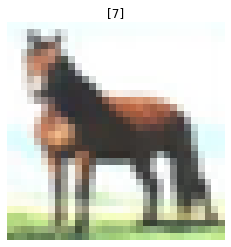

In [7]:
image, label = next(iter(_train_ds))
show_img(image, label.numpy())

In [8]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-15, 15), axes=(-3,-2), reshape=False)
    return image

def preprocessing(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    
    ## Computationally heavy preprocessing
    image_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(image_shape)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

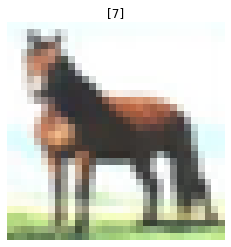

In [9]:
image, label = next(iter(_train_ds))
show_img(image, label.numpy())

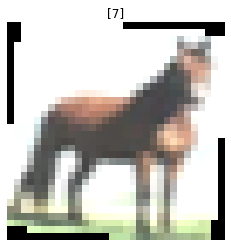

In [10]:
image, label = next(iter(_train_ds.batch(2).map(preprocessing)))
show_img(image[0], label[0].numpy())

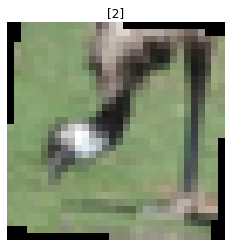

In [11]:
show_img(image[1], label[1].numpy())

In [12]:
tmp_it = iter(_train_ds.repeat().shuffle(2048))
%timeit next(tmp_it)

199 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
tmp_it = iter(_train_ds.map(preprocessing).repeat().shuffle(2048))
%timeit next(tmp_it)

1.35 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Training

In [14]:
batch_size = 128
epochs = 10

In [15]:
model    = get_compiled_toy_ResNet()
train_ds = _train_ds.shuffle(2048).batch(batch_size)
val_ds   = _val_ds.batch(batch_size)

history  = model.fit(train_ds, epochs=2, verbose=1, validation_data=val_ds)

Epoch 1/2
293/293 [==============================] - 5s 16ms/step - loss: 1.9252 - accuracy: 0.2913 - val_loss: 3.3565 - val_accuracy: 0.1156
Epoch 2/2
293/293 [==============================] - 4s 15ms/step - loss: 1.4744 - accuracy: 0.4748 - val_loss: 1.4684 - val_accuracy: 0.4838


In [16]:
model    = get_compiled_toy_ResNet()
train_ds = _train_ds.shuffle(2048).map(preprocessing).batch(batch_size)
val_ds   = _val_ds.batch(batch_size)

history  = model.fit(train_ds, epochs=2, verbose=1, validation_data=val_ds)

Epoch 1/2
293/293 [==============================] - 45s 152ms/step - loss: 2.0198 - accuracy: 0.2597 - val_loss: 2.9816 - val_accuracy: 0.1041
Epoch 2/2
293/293 [==============================] - 44s 152ms/step - loss: 1.5771 - accuracy: 0.4321 - val_loss: 1.4157 - val_accuracy: 0.5024


In [98]:
model    = get_compiled_toy_ResNet()
train_ds = _train_ds.shuffle(2048).cache().map(preprocessing).batch(batch_size)
val_ds   = _val_ds.batch(batch_size)

history  = model.fit(train_ds, epochs=2, verbose=1, validation_data=val_ds)

Epoch 1/2
293/293 [==============================] - 45s 152ms/step - loss: 2.0109 - accuracy: 0.2611 - val_loss: 2.8601 - val_accuracy: 0.1270
Epoch 2/2
293/293 [==============================] - 43s 148ms/step - loss: 1.5796 - accuracy: 0.4291 - val_loss: 1.3367 - val_accuracy: 0.5169


In [17]:
model    = get_compiled_toy_ResNet()
train_ds = _train_ds.shuffle(2048).cache().map(preprocessing,
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
val_ds   = _val_ds.batch(batch_size)

history  = model.fit(train_ds, epochs=2, verbose=1, validation_data=val_ds)

Epoch 1/2
293/293 [==============================] - 25s 86ms/step - loss: 2.0093 - accuracy: 0.2613 - val_loss: 2.2516 - val_accuracy: 0.1632
Epoch 2/2
293/293 [==============================] - 25s 85ms/step - loss: 1.5705 - accuracy: 0.4312 - val_loss: 1.3863 - val_accuracy: 0.5129


In [ ]:
model    = get_compiled_toy_ResNet()
train_ds = _train_ds.shuffle(2048).cache().batch(batch_size).map(preprocessing,
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds   = _val_ds.batch(batch_size)

history  = model.fit(train_ds, epochs=2, verbose=1, validation_data=val_ds)

Epoch 1/2
 37/293 [==>...........................] - ETA: 7s - loss: 2.4557 - accuracy: 0.1514